In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import *
from feat_functions import *
import time
import joblib
import json
import gc

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import bayes_opt
from imblearn import under_sampling, over_sampling, pipeline
from sklearn.metrics import roc_curve, roc_auc_score, balanced_accuracy_score, fbeta_score, confusion_matrix

import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from sklearn.base import clone

import shap

# 1. Feature engineering et exploration

## 1.1. Feature extraction

Pour les besoins de ce projet, le kernel Kaggle disponible à [cette addresse](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script) a été utilisé, avec quelques adaptations, notamment pour éviter les divisions par 0. Ce prétraitement met en place un one-hot encoding pour les variables catégorielles, et inclus des données statistiques sur les variables historiques (min, max, moyenne observés).

In [3]:
complete_set, challenge_set = feat_engineering()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 10s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 13s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 7s
Installments payments df shape: (339587, 26)
Process installments payments - done in 17s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 14s


Nous enregistrons le set de test.

In [4]:
challenge_set.to_csv('data/challenge_set.csv', index=False)

In [5]:
print(f"La base d'entraînement contient {complete_set.shape[0]} lignes, et {complete_set.shape[1]} colonnes.")

La base d'entraînement contient 307511 lignes, et 797 colonnes.


Nous observons les premières lignes de la base de données.

In [6]:
complete_set.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
index,,,,,,,,,,,,,,,,,,,,,
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2. Analyse des données manquantes

Notre base de données contient vraisemblablement des données manquantes. Nous explorons rapidement celles-ci.

In [7]:
na_vars = complete_set.isna().sum(axis=0)/complete_set.shape[0]
na_vars[na_vars>0].sort_values(ascending=False)

REFUSED_AMT_DOWN_PAYMENT_MIN     0.853111
REFUSED_AMT_DOWN_PAYMENT_MAX     0.853111
REFUSED_AMT_DOWN_PAYMENT_MEAN    0.853111
REFUSED_RATE_DOWN_PAYMENT_MIN    0.853111
REFUSED_RATE_DOWN_PAYMENT_MAX    0.853111
                                   ...   
ANNUITY_INCOME_PERC              0.000039
YEARLY_PAYMENT_RATE              0.000039
CNT_FAM_MEMBERS                  0.000007
INCOME_PER_PERSON                0.000007
DAYS_LAST_PHONE_CHANGE           0.000003
Length: 616, dtype: float64

616 variables contiennent des données manquantes, dont certaintes sont manquantes à plus de 85%. Il peut être intéressant de décider d'une stratégie d'imputation pour celles-ci.

In [8]:
print(f"La valeur minimale dans les données d'entraînement est {complete_set.min().min():,.0f}.")

La valeur minimale dans les données d'entraînement est -6,981,558.


Afin de limiter les étapes de prétraitement, notamment en termes de normalisation et de log-transformation, nous nous concentrerons sur des algorithmes de classification à base d'arbres.
Nous proposons, dans ce contexte, d'imputer les valeurs manquantes par -99 999 999, valeur très éloignée des valeurs observées dans la base de données.

In [9]:
na_imputer = SimpleImputer(strategy='constant', fill_value=-99999999)

## 1.3. Conception d'une fonction coût métier

Dans le contexte particulier de notre client, nous allons étudier l'utilité d'une fonction de coût métier spécifique. Le principe étant que toutes les erreurs de prédiction n'ont pas nécessairement le même impact, notamment financier. Pour cela, nous allons, de manière simpliste, analyser les pertes potentielles liées à un faux positif et à un faux négatif.

In [10]:
cash_loans = complete_set.loc[complete_set['NAME_CONTRACT_TYPE_Cashloans'] == 1,
                              ['TARGET', 'AMT_CREDIT', 'AMT_GOODS_PRICE']].groupby(['TARGET']).mean()
cash_loans['TOTAL_RATE'] = cash_loans['AMT_CREDIT'] / cash_loans['AMT_GOODS_PRICE'] - 1
cash_loans

,AMT_CREDIT,AMT_GOODS_PRICE,TOTAL_RATE
TARGET,,,
0.0,632461.030097,565645.39481,0.118123
1.0,578598.766181,504756.54455,0.146293


In [11]:
print(f"Nous constatons qu'en moyenne, les crédits accordés sans défaut rapportent {cash_loans.loc[0.0, 'TOTAL_RATE']:.1%} à la société de financement.")

Nous constatons qu'en moyenne, les crédits accordés sans défaut rapportent 11.8% à la société de financement.


Par conséquent, un faux positif (refus d'un prêt qui aurait pu être remboursé) conduit en moyenne à un manque à gagner direct de 11.8% du crédit (en ignorant le coût du financement pour l'entreprise), auquel s'ajoutent l'éventuelle perte d'activité future avec le client. 

En comparaison, un faux négatif (accord d'un prêt qui ne peut pas être remboursé) peut faire porter au financeur une perte pouvant aller jusqu'à 100% du crédit, à laquelle s'ajoute le temps passé pour élaborer le crédit, ainsi que son coût de financement pour l'entreprise.

Aussi, nous proposons de définir une fonction de coût métier de la manière suivante :

$loss(FPos, FNeg) = FPos + \beta*FNeg$

en utilisant une valeur de $\beta$ = 10, donnant donc un poids 10 fois supérieur aux faux négatifs par rapport aux faux positifs.

In [12]:
def custom_bin_loss(y_true:np.ndarray, y_pred:np.ndarray, fn_weight:float) -> int:
    
    """
    Fonction calculant le coût métier associé à une prédiction donnée.
    Formule : 
        cout(FP, FN) = FP + fn_weight*FN
    avec FP = faux positifs
         FN = faux négatifs
    """
    
    true_p_map = y_true == 1
    y_diff = y_true - y_pred
    loss = (fn_weight)*(y_diff[true_p_map]).sum() - y_diff[~true_p_map].sum()
    return int(loss)

## 1.4. Elaboration des sets d'entraînement et validation

Pour commencer, nous séparons notre donnée d'entraînement en une base contenant les variables client, et une contenant les cibles.

In [13]:
X = complete_set.drop(columns=['SK_ID_CURR', 'TARGET'])
y = complete_set['TARGET'].astype(int)
del complete_set
gc.collect()

0

Nous pouvons désormais étudier l'équilibre des classes cibles dans la base de données.

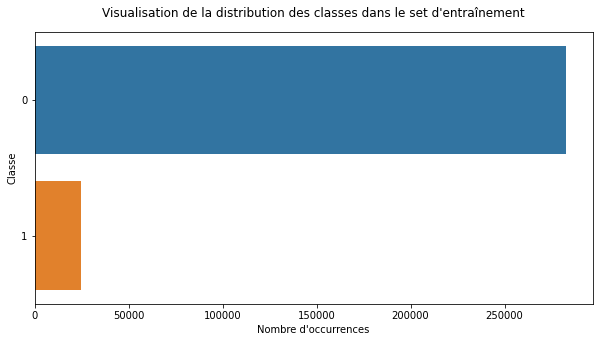

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(
    y=y
)

ax.set_xlabel("Nombre d'occurrences")
ax.set_ylabel("Classe")
ax.set_title("Visualisation de la distribution des classes dans le set d'entraînement",
             pad=15)

plt.show()

Nous constatons que les classes sont fortement déséquilibrées, et qu'il convient donc d'inclure une méthode d'équilibrage des données.

Pour la suite du projet, nous créons un set d'entraînement et un set de validation, à partir du set contenant les données complètes. Compte tenu du nombre d'observations, en particulier rapporté au nombre de variables, nous retenons une approche entraînement / validation avec une optimisation bayésienne pour l'identification des hyperparamètres. Le set de validation contiendra 20% des données.

In [15]:
X_train, X_valid, y_train, y_valid =\
    train_test_split(X, y, test_size=.2, stratify=y, random_state=52)

# 2. Choix du modèle

## 2.1. Définition des modèles à explorer

Dans un premier temps, nous allons définir un ensemble de modèles dont nous souhaitons comparer les performances, et optimiser leurs hyperparamètres. Afin d'accélérer cette étape, nous utiliserons l'under-sampling comme méthode d'équilibrage des données.

In [17]:
rus = under_sampling.RandomUnderSampler(random_state=52)

### 2.1.1. LGBoost

Nous commençons par le modèle LGBoost, modèle de boosting à base d'arbres.

In [23]:
def objective(num_leaves, n_estimators, reg_alpha, reg_lambda, min_child_samples ):
    
    """
    Fonction définissant un objectif à optimiser (maximiser), par optimisation bayésienne.
    """
    
    model = lgb.LGBMClassifier(
        objective='binary',
        # scale_pos_weight=10,
        num_leaves=int(round(num_leaves,0)),
        n_estimators=int(round(n_estimators,0)),
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_child_samples=int(round(min_child_samples,0)),
        random_state=53)

    select_model = pipeline.Pipeline([('imputer', na_imputer),
                                      ('sampler', rus),
                                      ('model', model)
                                     ])
    
    select_model.fit(X_train, y_train)
    
    y_score = select_model.predict(X_valid)
    loss = custom_bin_loss(y_valid, y_score, 10)
    
    return -loss # Maximisation de la neg loss

In [24]:
search_space = {
    'num_leaves': (20,50),
    'n_estimators': (100,1000),
    'reg_alpha': (0,1),
    'reg_lambda': (0,1),
    'min_child_samples': (10,50)
}

In [25]:
optimizer = bayes_opt.BayesianOptimization(
    f=objective,
    pbounds=search_space,
    random_state=53
)

In [26]:
optimizer.maximize()

|   iter    |  target   | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------
|  1        | -3.107e+0 |  43.87    |  605.0    |  33.65    |  0.3522   |  0.5859   |
|  2        | -3.128e+0 |  31.43    |  844.7    |  27.94    |  0.4784   |  0.3478   |
|  3        | -3.1e+04  |  15.38    |  334.0    |  21.43    |  0.3943   |  0.3716   |
|  4        | -3.085e+0 |  32.27    |  907.7    |  25.02    |  0.4072   |  0.6524   |
|  5        | -3.122e+0 |  32.71    |  609.9    |  35.73    |  0.6076   |  0.1282   |
|  6        | -3.09e+04 |  19.03    |  288.5    |  23.9     |  0.3875   |  0.4957   |
|  7        | -3.117e+0 |  33.05    |  910.3    |  22.87    |  0.7564   |  0.7542   |
|  8        | -3.094e+0 |  21.93    |  785.3    |  21.58    |  0.7116   |  0.8957   |
|  9        | -3.13e+04 |  16.36    |  751.7    |  25.83    |  0.3595   |  0.03908  |
|  10       | -3.134e+0 |  47.9     |  540.5    |  35.

In [27]:
params = optimizer.max['params']
params['num_leaves'] = int(round(params['num_leaves'],0))
params['n_estimators'] = int(round(params['n_estimators'],0))
params['min_child_samples'] = int(round(params['min_child_samples'],0))

Nous définissons désormais le modèle avec les hyperparamètres identifiés.

In [28]:
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    metric='accuracy',
    # scale_pos_weight=10,
    random_state=53
)

lgb_model.set_params(**params)

LGBMClassifier(metric='accuracy', n_estimators=288, num_leaves=25,
               objective='binary', random_state=53,
               reg_alpha=0.5207205272522514, reg_lambda=0.6036103389804524)

### 2.1.2. CatBoost

Nous incluons un modèle CatBoost, autre implémentation d'une approche de boosting à base d'arbres.

In [29]:
def objective(rsm, l2_leaf_reg, iterations):
    
    """
    Fonction définissant un objectif à optimiser (maximiser), par optimisation bayésienne.
    """
    
    model = cb.CatBoostClassifier(
        iterations=int(round(iterations,0)),
        rsm=rsm,
        l2_leaf_reg=l2_leaf_reg,
        # scale_pos_weight=10,
        silent=True,
        random_seed=53)

    select_model = pipeline.Pipeline([('imputer', na_imputer),
                                      ('sampler', rus),
                                      ('model', model)
                                     ])
    
    select_model.fit(X_train, y_train)
    
    y_score = select_model.predict(X_valid)
    loss = custom_bin_loss(y_valid, y_score, 10)
    
    return -loss # Maximisation de la neg loss

In [30]:
search_space = {
    'rsm': (0.1,0.9),
    'l2_leaf_reg': (0,1),
    'iterations': (100,1000)
}

In [31]:
optimizer = bayes_opt.BayesianOptimization(
    f=objective,
    pbounds=search_space,
    random_state=53
)

In [32]:
optimizer.maximize()

|   iter    |  target   | iterat... | l2_lea... |    rsm    |
-------------------------------------------------------------
|  1        | -3.067e+0 |  862.0    |  0.5612   |  0.4639   |
|  2        | -3.124e+0 |  417.0    |  0.5859   |  0.5286   |
|  3        | -3.053e+0 |  844.7    |  0.2645   |  0.4827   |
|  4        | -3.146e+0 |  413.0    |  0.1345   |  0.308    |
|  5        | -3.249e+0 |  142.9    |  0.3943   |  0.3973   |
|  6        | -3.069e+0 |  815.3    |  1.0      |  0.9      |
|  7        | -3.1e+04  |  455.3    |  0.9839   |  0.6611   |
|  8        | -3.082e+0 |  776.7    |  0.0      |  0.1      |
|  9        | -3.083e+0 |  903.4    |  0.0      |  0.9      |
|  10       | -3.062e+0 |  736.9    |  1.0      |  0.9      |
|  11       | -3.078e+0 |  706.3    |  0.01623  |  0.1884   |
|  12       | -3.055e+0 |  945.2    |  0.3948   |  0.3696   |
|  13       | -3.04e+04 |  972.9    |  1.0      |  0.9      |
|  14       | -3.069e+0 |  1e+03    |  0.0      |  0.1      |
|  15   

In [33]:
params = optimizer.max['params']
params['iterations'] = int(round(params['iterations'],0))

In [34]:
cb_model = cb.CatBoostClassifier(
    # scale_pos_weight=10,
    silent=True,
    random_seed=53
)
cb_model.set_params(**params)

### 2.1.3. XGBoost

Nous incluons une dernière approche de boosting, celle du XGBoost.

In [35]:
def objective(n_estimators, max_depth, reg_alpha, reg_lambda, colsample_bytree):
    
    """
    Fonction définissant un objectif à optimiser (maximiser), par optimisation bayésienne.
    """
    
    model = xgb.XGBClassifier(
        n_estimators=int(round(n_estimators,0)),
        max_depth=int(round(max_depth,0)),
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        colsample_bytree=colsample_bytree,
        # scale_pos_weight=10,
        booster='gbtree',
        n_jobs=-1,
        random_state=53)

    select_model = pipeline.Pipeline([('imputer', na_imputer),
                                      ('sampler', rus),
                                      ('model', model)
                                     ])
    
    select_model.fit(X_train, y_train)
    
    y_score = select_model.predict(X_valid)
    loss = custom_bin_loss(y_valid, y_score, 10)
    
    return -loss # Maximisation de la neg loss

In [36]:
search_space = {
    'n_estimators': (100,1000),
    'max_depth': (5,10),
    'reg_alpha': (0,1),
    'reg_lambda': (0,1),
    'colsample_bytree': (0.1,0.9)
}

In [37]:
optimizer = bayes_opt.BayesianOptimization(
    f=objective,
    pbounds=search_space,
    random_state=53
)

In [38]:
optimizer.maximize()

|   iter    |  target   | colsam... | max_depth | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------
|  1        | -3.198e+0 |  0.7773   |  7.806    |  509.4    |  0.3522   |  0.5859   |
|  2        | -3.186e+0 |  0.5286   |  9.137    |  338.1    |  0.4784   |  0.3478   |
|  3        | -3.252e+0 |  0.2076   |  6.3      |  142.9    |  0.3943   |  0.3716   |
|  4        | -3.206e+0 |  0.5454   |  9.487    |  250.6    |  0.4072   |  0.6524   |
|  5        | -3.204e+0 |  0.5542   |  7.833    |  571.9    |  0.6076   |  0.1282   |
|  6        | -3.246e+0 |  0.6409   |  9.213    |  328.8    |  0.1444   |  0.3696   |
|  7        | -3.204e+0 |  0.1924   |  5.346    |  130.5    |  0.3913   |  0.1542   |
|  8        | -3.251e+0 |  0.3385   |  8.807    |  147.5    |  0.7116   |  0.8957   |
|  9        | -3.216e+0 |  0.4693   |  9.096    |  343.1    |  0.6573   |  0.3339   |
|  10       | -3.203e+0 |  0.1711   |  5.353    |  338

In [39]:
params = optimizer.max['params']
params['n_estimators'] = int(round(params['n_estimators'],0))
params['max_depth'] = int(round(params['max_depth'],0))

In [40]:
xgb_model = xgb.XGBClassifier(
    booster='gbtree',
    # scale_pos_weight=10,
    n_jobs=-1,
    random_state=53
)
xgb_model.set_params(**params)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7718464790274386, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=790, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=53,
              reg_alpha=0.19717266306739634, reg_lambda=0.24977899848494378, ...)

### 2.1.4. Random Forest

Nous incluons également un modèle de bagging, un classificateur à base de Random Forest.

In [41]:
def objective(n_estimators, max_depth, max_features):
    
    """
    Fonction définissant un objectif à optimiser (maximiser), par optimisation bayésienne.
    """
    
    model = RandomForestClassifier(
        n_estimators=int(round(n_estimators,0)),
        max_depth=int(round(max_depth,0)),
        max_features=max_features,
        n_jobs=8,
        random_state=53)

    select_model = pipeline.Pipeline([('imputer', na_imputer),
                                      ('sampler', rus),
                                      ('model', model)
                                     ])
    
    select_model.fit(X_train, y_train)
    
    y_score = select_model.predict(X_valid)
    loss = custom_bin_loss(y_valid, y_score, 10)
    
    return -loss # Maximisation de la neg loss

In [42]:
search_space = {
    'n_estimators': (100,500),
    'max_depth': (5,10),
    'max_features': (0.1,0.5)
}

In [43]:
optimizer = bayes_opt.BayesianOptimization(
    f=objective,
    pbounds=search_space,
    random_state=53
)

In [44]:
optimizer.maximize()

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        | -3.34e+04 |  9.233    |  0.3245   |  282.0    |
|  2        | -3.444e+0 |  6.761    |  0.3343   |  314.3    |
|  3        | -3.333e+0 |  9.137    |  0.2058   |  291.4    |
|  4        | -3.375e+0 |  6.739    |  0.1538   |  204.0    |
|  5        | -3.505e+0 |  5.238    |  0.2577   |  248.6    |
|  6        | -3.399e+0 |  8.005    |  0.4167   |  177.5    |
|  7        | -3.402e+0 |  8.226    |  0.3681   |  292.1    |
|  8        | -3.494e+0 |  5.416    |  0.2604   |  147.5    |
|  9        | -3.373e+0 |  8.665    |  0.363    |  290.5    |
|  10       | -3.31e+04 |  9.97     |  0.1612   |  292.2    |
|  11       | -3.304e+0 |  9.612    |  0.1603   |  279.3    |
|  12       | -3.347e+0 |  7.165    |  0.1015   |  279.3    |
|  13       | -3.344e+0 |  10.0     |  0.5      |  276.8    |
|  14       | -3.369e+0 |  6.24     |  0.1      |  274.8    |
|  15   

In [45]:
params = optimizer.max['params']
params['n_estimators'] = int(round(params['n_estimators'],0))
params['max_depth'] = int(round(params['max_depth'],0))

In [46]:
rf_model = RandomForestClassifier(
    n_jobs=8,
    random_state=53
)
rf_model.set_params(**params)

RandomForestClassifier(max_depth=10, max_features=0.1, n_estimators=272,
                       n_jobs=8, random_state=53)

## 2.2. Choix du modèle

Nous comparons désormais les modèles entre eux. Pour ce faire, nous nous concentrerons sur la fonction de coût métier, mais pourrons tenir compte d'autres mesures, comme notamment le temps d'entraînement et le score AUC.

In [47]:
models = [lgb_model, cb_model, xgb_model, rf_model]
model_names = ['LGB', 'ClassBoost', 'XGB', 'RF']
roc_list = []
scores_list = []

for model, name in zip(models, model_names):
    score_dict = {}
    score_dict['model'] = name
    roc_dict = {}
    roc_dict['model'] = name
    select_model = pipeline.Pipeline([('imputer', na_imputer),
                                      ('sampler', rus),
                                      ('model', model)
                                     ])
    t0 = time.time()
    select_model.fit(X_train, y_train)
    score_dict['train_time'] = time.time()-t0
    
    t0 = time.time()
    probs = select_model.predict_proba(X_valid)
    score_dict['pred_time'] = time.time()-t0
    
    y_pred = select_model.predict(X_valid)
    
    fpr, tpr, thresh = roc_curve(y_valid, probs[:,1], pos_label=1)
    roc_dict['fpr'] = fpr
    roc_dict['tpr'] = tpr
    roc_list.append(roc_dict)
    
    score_dict['Neg_Loss'] = -custom_bin_loss(y_valid, y_pred, 10)
    score_dict['AUC'] = roc_auc_score(y_valid, probs[:,1])
    score_dict['Bal_Accuracy'] = balanced_accuracy_score(y_valid, y_pred)
    score_dict['Fbeta'] = fbeta_score(y_valid, y_pred, beta=10)
    scores_list.append(score_dict)
    
    del t0, probs, y_pred, fpr, tpr, thresh, roc_dict, score_dict, select_model
    gc.collect()

In [48]:
# ROC pour modèle aléatoitre(fpr = tpr), pour visualisation
random_probs = [0 for i in range(len(y_valid))]
p_fpr, p_tpr, _ = roc_curve(y_valid, random_probs, pos_label=1)

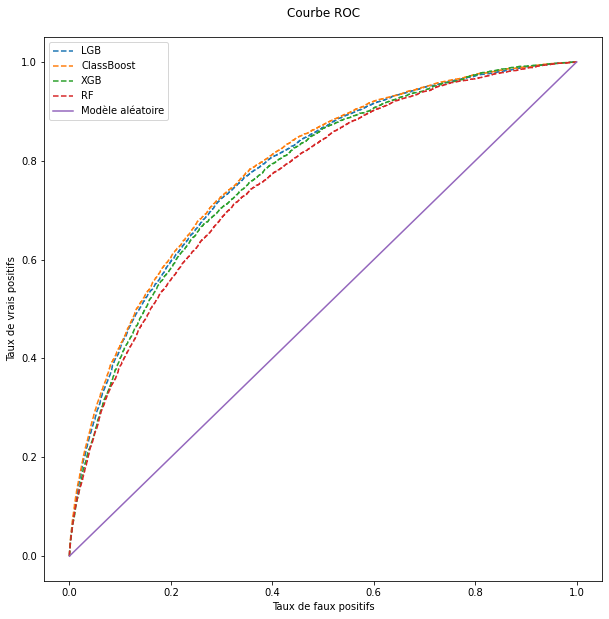

In [49]:
plt.figure(figsize=(10,10))
for roc in roc_list:
    plt.plot(roc['fpr'], roc['tpr'], linestyle='--', label=roc['model'])
plt.plot(p_fpr, p_tpr, linestyle='-', label='Modèle aléatoire')
plt.legend()
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC', pad=20)
plt.show()

In [50]:
scores_list = pd.DataFrame.from_dict(scores_list)
scores_list.set_index('model', inplace=True)
scores_list

,train_time,pred_time,Neg_Loss,AUC,Bal_Accuracy,Fbeta
model,,,,,,
LGB,6.410937,0.706575,-30658,0.780605,0.711647,0.696101
ClassBoost,93.963049,0.528234,-30397,0.785643,0.714029,0.697538
XGB,69.026115,0.810480,-31622,0.771934,0.702435,0.684693
RF,16.008961,0.777058,-32667,0.760097,0.692801,0.677534


In [51]:
nrow, ncols = get_n_rowcol(scores_list.columns)

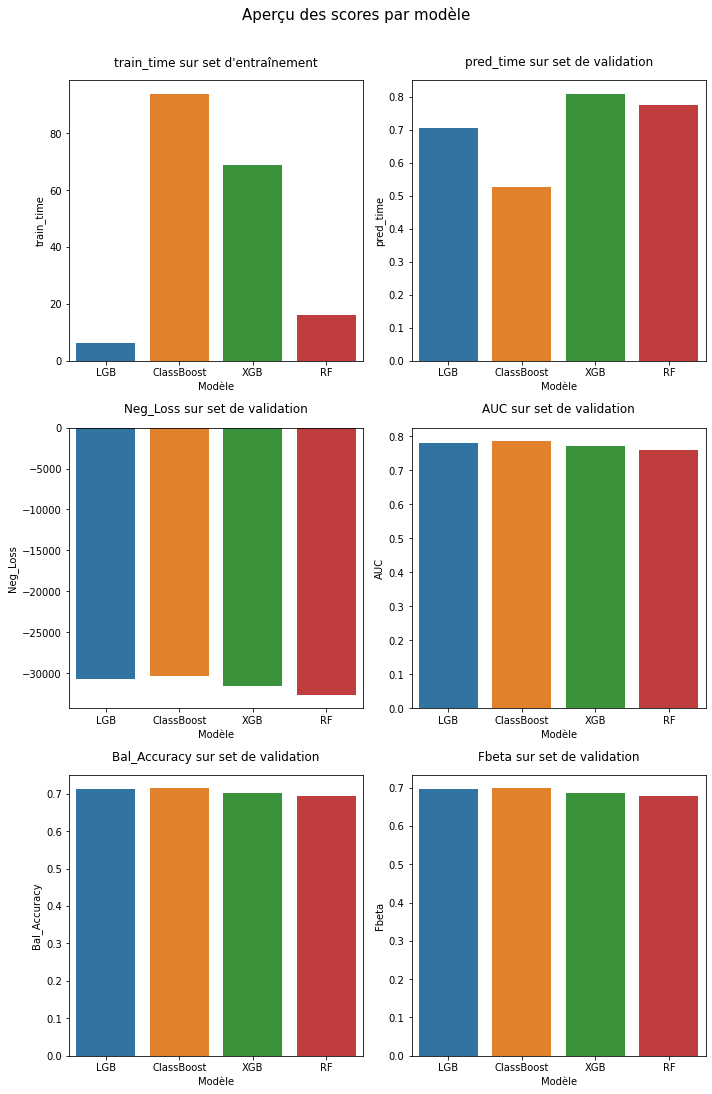

In [52]:
fig, axes = plt.subplots(nrow, ncols, figsize=(ncols*5, nrow*5))

for ax, metric in zip(fig.axes, scores_list.columns):
    sns.barplot(
        x=scores_list.index,
        y=scores_list[metric],
        ax=ax
    )
    if metric == 'train_time':
        ax.set_title(f"{metric} sur set d'entraînement", pad=15)
    else:
        ax.set_title(f"{metric} sur set de validation", pad=15)
    ax.set_xlabel("Modèle")
fig.suptitle("Aperçu des scores par modèle", y=1.01, fontsize=15)
fig.set_tight_layout(True)
plt.show()

In [53]:
best_name = scores_list['Neg_Loss'].idxmax()
print(f"Le meilleur score est obtenu avec le modèle {best_name}, avec un coût métier de {-scores_list['Neg_Loss'].max():.3f} sur set de validation.")

Le meilleur score est obtenu avec le modèle ClassBoost, avec un coût métier de 30397.000 sur set de validation.


Néanmoins, les scores obtenus avec le modèle LGBoost étant proches, et le temps d'entraînement étant pratiquement un ordre de grandeur inférieur, nous proposons de retenir ce dernier.

In [54]:
model = lgb_model
model

LGBMClassifier(metric='accuracy', n_estimators=288, num_leaves=25,
               objective='binary', random_state=53,
               reg_alpha=0.5207205272522514, reg_lambda=0.6036103389804524)

## 2.3. Choix de la méthode de sampling

Nous nous intéressons désormais à la méthode de sampling. Pour le moment, nous avons retenu un under-sampling, pour des raisons de rapidité d'entraînement. Néanmoins, cette méthode ne nous permet pas d'utiliser la base complète. Nous allons donc comparer la performance obtenue en utilisant l'under-sampling, l'over-sampling, et une méthode SMOTE (plus risquée, compte tenu de la quantité de valeurs imputées).

In [55]:
rus = under_sampling.RandomUnderSampler(random_state=52)
ros = over_sampling.RandomOverSampler(random_state=52)
smote = over_sampling.SMOTE(random_state=52)

In [56]:
samplers = [rus, ros, smote]
sampler_names = ['Under Sampling', 'Over Sampling', 'SMOTE']

In [57]:
roc_list = []
scores_list = []

for sampler, name in zip(samplers, sampler_names):
    score_dict = {}
    score_dict['sampler'] = name
    roc_dict = {}
    roc_dict['sampler'] = name
    sampler_model = pipeline.Pipeline([('imputer', na_imputer),
                                       ('sampler', sampler),
                                       ('model', model)
                                      ])
    
    t0 = time.time()
    sampler_model.fit(X_train, y_train)
    score_dict['train_time'] = time.time()-t0
    
    t0 = time.time()
    probs = sampler_model.predict_proba(X_valid)
    score_dict['pred_time'] = time.time()-t0
    
    y_pred = sampler_model.predict(X_valid)
       
    fpr, tpr, thresh = roc_curve(y_valid, probs[:,1], pos_label=1)
    roc_dict['fpr'] = fpr
    roc_dict['tpr'] = tpr
    roc_list.append(roc_dict)
    
    score_dict['Neg_Loss'] = -custom_bin_loss(y_valid, y_pred, 10)
    score_dict['AUC'] = roc_auc_score(y_valid, probs[:,1])
    score_dict['Bal_Accuracy'] = balanced_accuracy_score(y_valid, y_pred)
    score_dict['Fbeta'] = fbeta_score(y_valid, y_pred, beta=10)
    scores_list.append(score_dict)
    
    del t0, probs, y_pred, fpr, tpr, thresh, roc_dict, score_dict, sampler_model
    gc.collect()

In [58]:
scores_list = pd.DataFrame.from_dict(scores_list)
scores_list.set_index('sampler', inplace=True)
scores_list

,train_time,pred_time,Neg_Loss,AUC,Bal_Accuracy,Fbeta
sampler,,,,,,
Under Sampling,6.311818,0.679714,-30658,0.780605,0.711647,0.696101
Over Sampling,29.953108,0.771994,-30087,0.787658,0.713666,0.651967
SMOTE,44.401688,0.768236,-47498,0.787447,0.521878,0.047156


In [59]:
best_name = scores_list['Neg_Loss'].idxmax()
print(f"Le meilleur modèle est obtenu avec la méthode {best_name}, avec un coût métier de {-scores_list['Neg_Loss'].max():.3f}.")

Le meilleur modèle est obtenu avec la méthode Over Sampling, avec un coût métier de 30087.000.


In [60]:
sampler = samplers[sampler_names.index(best_name)]
sampler

RandomOverSampler(random_state=52)

In [61]:
model = pipeline.Pipeline([('imputer', na_imputer),
                           ('sampler', sampler),
                           ('model', model)
                          ])

In [62]:
model.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=-99999999, strategy='constant')),
                ('sampler', RandomOverSampler(random_state=52)),
                ('model',
                 LGBMClassifier(metric='accuracy', n_estimators=288,
                                num_leaves=25, objective='binary',
                                random_state=53, reg_alpha=0.5207205272522514,
                                reg_lambda=0.6036103389804524))])

## 2.4. Réduction du nombre de features du modèle

Afin d'optimiser encore les temps d'entraînement du modèle, mais également pour en faciliter l'exploitation et l'explication, nous allons réduire le nombre de variables utilisées. En effet, si nous utilisons pour le moment presque 800 variables, cela n'est pas utilisable pour expliquer leur impact individuel au client potentiel.

Nous essaierons de retenir environ 20 variables au total. Pour ce faire, nous mettons en place 3 méthodes en parallèle :
- une méthode sur base d'ANOVA entre variables et cible (efficace pour les variables corrélées linéairement)
- une méthode sur base de permutation, permettant d'identifier les variables ayant le plus fort impact sur les prédictions
- une méthode basée sur l'importance des variables dans le modèle lui-même

In [65]:
features = model.feature_names_in_

In [66]:
n_top = 10

### 2.4.1. ANOVA

Cette approche est mise en oeuvre dans la fonction SelectKBest() de scikit-learn. Nous l'utilisons donc, et retenons les 10 plus fortes corrélations.

In [70]:
kbest = SelectKBest(score_func=f_classif, k=n_top)
kbest.fit(na_imputer.fit_transform(X_train), y_train)

SelectKBest()

In [71]:
kbest_feats = features[kbest.get_support()].tolist()

### 2.4.2. Permutations

Cette approche est mise en oeuvre dans la fonction permutation_importance() de scikit-learn. Nous l'utilisons donc, et retenons les 10 plus fortes corrélations.

In [72]:
def neg_loss(model, X_valid, y_true):
    return -custom_bin_loss(y_true, model.predict(X_valid), 10)

In [73]:
result = permutation_importance(
    model, X_valid, y_valid,
    scoring=neg_loss,
    n_repeats=20,
    max_samples=.2,
    random_state=52,
    n_jobs=8
)

In [74]:
feat_imp = pd.Series(result.importances_mean, index=features)

In [75]:
perm_feats = feat_imp.nlargest(n_top).index.tolist()

### 2.4.3. Feature importance

Cette approche se base sur la définition des feature importance dans le modèle.

In [76]:
feat_imp = model.named_steps['model'].feature_importances_
top_feats_idx = np.argsort(feat_imp)[-n_top:]
f_imp_feats = features[top_feats_idx].tolist()

### 2.4.4. Combinaison et entraînement du modèle réduit

Nous pouvons désormais combiner les variables identifiées par ces trois approches.

In [77]:
top_features = list(set(kbest_feats).union(set(perm_feats)).union(set(f_imp_feats)))
top_features

['REFUSED_APP_CREDIT_PERC_VAR',
 'REGION_RATING_CLIENT',
 'EXT_SOURCE_1',
 'REFUSED_AMT_CREDIT_MAX',
 'REFUSED_DAYS_DECISION_MEAN',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_3',
 'DAYS_ID_PUBLISH',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'YEARLY_PAYMENT_RATE',
 'NAME_EDUCATION_TYPE_Highereducation',
 'REFUSED_AMT_APPLICATION_MAX',
 'REGION_RATING_CLIENT_W_CITY',
 'AMT_GOODS_PRICE',
 'INSTAL_DPD_MEAN',
 'CODE_GENDER',
 'AMT_CREDIT',
 'REFUSED_DAYS_DECISION_MAX',
 'EXT_SOURCE_2',
 'NAME_INCOME_TYPE_Working']

In [78]:
print(f"Nous retenons ces {len(top_features)} variables pour notre modèles final.")

Nous retenons ces 21 variables pour notre modèles final.


Nous pouvons désormais entraîner le modèle avec ce nombre réduit de variables. Nous optimisons de nouveau les hyperparamètres de celui-ci.

In [79]:
reduced_model = clone(model)

In [80]:
import bayes_opt

In [81]:
def objective(model__num_leaves, model__n_estimators, model__reg_alpha, model__reg_lambda, model__min_child_samples):
    reduced_model.set_params(**{
        'model__num_leaves':int(round(model__num_leaves,0)),
        'model__n_estimators':int(round(model__n_estimators,0)),
        'model__reg_alpha':model__reg_alpha,
        'model__reg_lambda':model__reg_lambda,
        'model__min_child_samples':int(round(model__min_child_samples,0)),
        'model__random_state':53})

    reduced_model.fit(X_train.loc[:,top_features], y_train)
    
    y_score = reduced_model.predict(X_valid.loc[:,top_features])
    loss = custom_bin_loss(y_valid, y_score, 10)
    
    return -loss

In [82]:
search_space = {
    'model__num_leaves': (20,50),
    'model__n_estimators': (100,1000),
    'model__reg_alpha': (0,1),
    'model__reg_lambda': (0,1),
    'model__min_child_samples': (10,50)
}

In [83]:
optimizer = bayes_opt.BayesianOptimization(
    f=objective,
    pbounds=search_space,
    random_state=53
)

In [84]:
optimizer.maximize()

|   iter    |  target   | model_... | model_... | model_... | model_... | model_... |
-------------------------------------------------------------------------------------
|  1        | -3.248e+0 |  43.87    |  605.0    |  33.65    |  0.3522   |  0.5859   |
|  2        | -3.272e+0 |  31.43    |  844.7    |  27.94    |  0.4784   |  0.3478   |
|  3        | -3.166e+0 |  15.38    |  334.0    |  21.43    |  0.3943   |  0.3716   |
|  4        | -3.268e+0 |  32.27    |  907.7    |  25.02    |  0.4072   |  0.6524   |
|  5        | -3.27e+04 |  32.71    |  609.9    |  35.73    |  0.6076   |  0.1282   |
|  6        | -3.206e+0 |  25.81    |  352.3    |  31.72    |  0.537    |  0.6086   |
|  7        | -3.183e+0 |  14.77    |  336.8    |  21.78    |  0.00922  |  0.3674   |
|  8        | -3.211e+0 |  23.61    |  325.9    |  24.11    |  1.0      |  0.5045   |
|  9        | -3.206e+0 |  10.0     |  326.9    |  20.0     |  1.0      |  0.0      |
|  10       | -3.219e+0 |  15.15    |  332.2    |  29.

In [85]:
params = optimizer.max['params']
params['model__num_leaves'] = int(round(params['model__num_leaves'],0))
params['model__n_estimators'] = int(round(params['model__n_estimators'],0))
params['model__min_child_samples'] = int(round(params['model__min_child_samples'],0))

In [86]:
reduced_model.set_params(**params)

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=-99999999, strategy='constant')),
                ('sampler', RandomOverSampler(random_state=52)),
                ('model',
                 LGBMClassifier(metric='accuracy', min_child_samples=25,
                                n_estimators=348, num_leaves=21,
                                objective='binary', random_state=53,
                                reg_alpha=0.2052027486239345,
                                reg_lambda=0.6287527879709023))])

In [87]:
reduced_model.fit(X_train.loc[:,top_features], y_train)

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=-99999999, strategy='constant')),
                ('sampler', RandomOverSampler(random_state=52)),
                ('model',
                 LGBMClassifier(metric='accuracy', min_child_samples=25,
                                n_estimators=348, num_leaves=21,
                                objective='binary', random_state=53,
                                reg_alpha=0.2052027486239345,
                                reg_lambda=0.6287527879709023))])

Nous pouvons désormais observer la matrice de confusion obtenue sur le set de validation.

In [88]:
y_pred = reduced_model.predict(X_valid.loc[:,top_features])

In [89]:
cm = confusion_matrix(y_valid, y_pred)

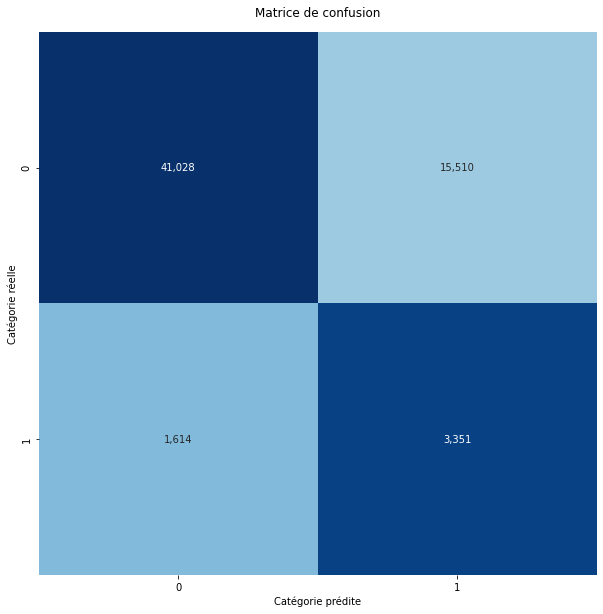

In [90]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(
    data=cm/cm.sum(axis=1).reshape(-1,1),
    ax=ax,
    cmap='Blues',
    vmin=0,
    cbar=False,
    annot=cm,
    fmt=',d'
)
ax.set_title(f"Matrice de confusion", pad=15)
ax.set_xlabel("Catégorie prédite")
ax.set_ylabel("Catégorie réelle")
plt.show()

Nous enregistrons également une base de données réduite ne contenant que ces variables.

In [33]:
data_set = challenge_set[features+['SK_ID_CURR']]
data_set.to_csv('data/reduced_data.csv', index=False)

## 2.5. Optimisation du threshold

Notre modèle, bien que choisi en fonction de notre coût métier, n'est pas directement construit sur la base de celui-ci (il n'est pas la base de la descente en gradient). Nous proposons d'étudier si un changement du threshold de sélection peut impacter la performance de celui-ci.

Nous commençons par calculer la perte obtenue sur le set de validation, sans optimisation du threshold de sélection.

In [92]:
y_pred = reduced_model.predict(X_valid.loc[:,top_features])
custom_bin_loss(y_valid, y_pred, 10)

31650

Pour pouvoir l'utiliser dans une logique scikit-learn classique, ainsi que dans une logique SHAP, nous définissons une classe avec les méthodes nécessaires, nous permettant de définir un threshold de sélection.

In [93]:
class loan_model():
    def __init__(self, model, pos_thresh):
        self.model = model
        self.pos_thresh = pos_thresh
    def fit(self, X, y):
        self.model.fit(X, y)
        return self.model
    def predict_proba(self, X):
        self.prob_pred_raw = self.model.predict_proba(X)
        self.prob_pred = self.prob_pred_raw - np.array(
            [.5-self.pos_thresh,
             self.pos_thresh-.5])
        return self.prob_pred
    def predict(self, X):
        self.y_pred = np.apply_along_axis(
            np.argmax,
            axis=1,
            arr=self.predict_proba(X))
        return self.y_pred

In [94]:
def objective(pos_thresh):
    model_obj = loan_model(reduced_model, pos_thresh)
    y_pred = model_obj.predict(X_valid.loc[:,top_features])
    loss = custom_bin_loss(y_valid, y_pred, 10)
    return -loss

In [95]:
search_space = {
    'pos_thresh': (0,1)
}

In [96]:
optimizer = bayes_opt.BayesianOptimization(
    f=objective,
    pbounds=search_space,
    random_state=53
)

In [97]:
optimizer.maximize()

|   iter    |  target   | pos_th... |
-------------------------------------
|  1        | -4.561e+0 |  0.8467   |
|  2        | -3.202e+0 |  0.5612   |
|  3        | -3.225e+0 |  0.4549   |
|  4        | -3.507e+0 |  0.3522   |
|  5        | -3.276e+0 |  0.5859   |
|  6        | -5.654e+0 |  0.0      |
|  7        | -3.162e+0 |  0.5097   |
|  8        | -3.176e+0 |  0.5267   |
|  9        | -3.162e+0 |  0.5097   |
|  10       | -4.965e+0 |  1.0      |
|  11       | -3.169e+0 |  0.4879   |
|  12       | -3.164e+0 |  0.5009   |
|  13       | -3.162e+0 |  0.5051   |
|  14       | -3.162e+0 |  0.5053   |
|  15       | -3.162e+0 |  0.5056   |
|  16       | -3.164e+0 |  0.5063   |
|  17       | -3.159e+0 |  0.505    |
|  18       | -3.16e+04 |  0.5034   |
|  19       | -3.16e+04 |  0.5023   |
|  20       | -3.162e+0 |  0.5015   |
|  21       | -3.16e+04 |  0.5022   |
|  22       | -4.35e+04 |  0.2155   |
|  23       | -3.163e+0 |  0.5019   |
|  24       | -3.159e+0 |  0.5027   |
|  25       

Nous visualisons le coût métier en fonction du threshold.

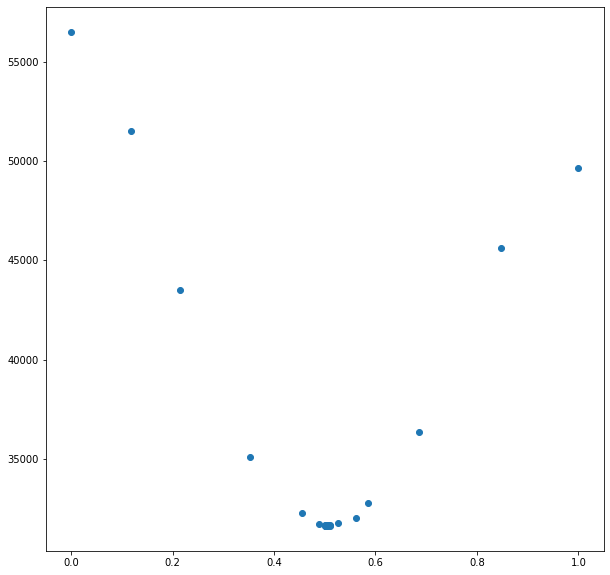

In [98]:
losses = [-x['target'] for x in optimizer.res]
pos_threshs = [x['params']['pos_thresh'] for x in optimizer.res]

fig, ax = plt.subplots(figsize = (10,10))

ax.scatter(
    x=pos_threshs,
    y=losses
)

plt.show()

Nous arrondissons au millième, pour éviter l'overfit.

In [100]:
pos_thresh = round(optimizer.max['params']['pos_thresh'], 3)
pos_thresh

0.505

Nous pouvons désormais définir le modèle, sur la base de notre classe dédiée.

In [101]:
model = loan_model(reduced_model, pos_thresh)
model.model

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=-99999999, strategy='constant')),
                ('sampler', RandomOverSampler(random_state=52)),
                ('model',
                 LGBMClassifier(metric='accuracy', min_child_samples=25,
                                n_estimators=348, num_leaves=21,
                                objective='binary', random_state=53,
                                reg_alpha=0.2052027486239345,
                                reg_lambda=0.6287527879709023))])

In [102]:
model.fit(X_train.loc[:,top_features], y_train)

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=-99999999, strategy='constant')),
                ('sampler', RandomOverSampler(random_state=52)),
                ('model',
                 LGBMClassifier(metric='accuracy', min_child_samples=25,
                                n_estimators=348, num_leaves=21,
                                objective='binary', random_state=53,
                                reg_alpha=0.2052027486239345,
                                reg_lambda=0.6287527879709023))])

Nous pouvons également observer le score et la matrice de confusion, pour la comparer aux précédentes.

In [103]:
y_pred = model.predict(X_valid.loc[:,top_features])
custom_bin_loss(y_valid, y_pred, 10)

31613

Nous remarquons que le coût est légèrement inférieur à la version initiale (threshold à 0.5).

In [104]:
cm = confusion_matrix(y_valid, y_pred)

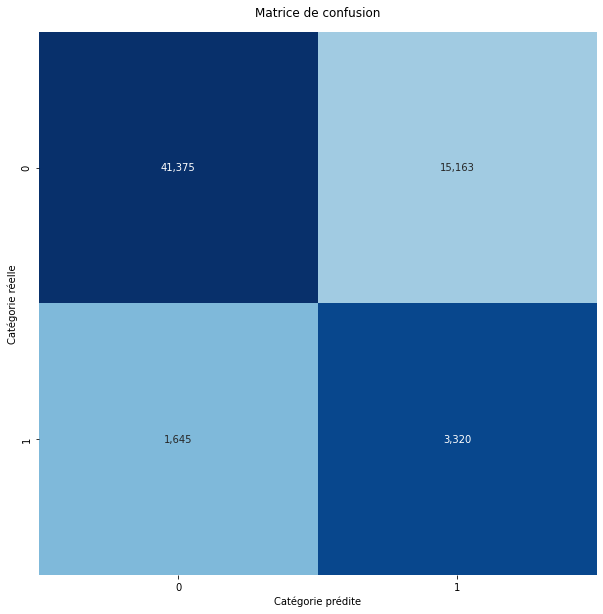

In [105]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(
    data=cm/cm.sum(axis=1).reshape(-1,1),
    ax=ax,
    cmap='Blues',
    vmin=0,
    cbar=False,
    annot=cm,
    fmt=',d'
)
ax.set_title(f"Matrice de confusion", pad=15)
ax.set_xlabel("Catégorie prédite")
ax.set_ylabel("Catégorie réelle")
plt.show()

Le modèle avec threshold modifié réduit le taux de faux positifs et augmente légèrement le taux de faux négatifs, mais dans un rapport permettant néanmoins d'améliorer le coût métier.

In [117]:
joblib.dump(model.model, 'models/final_model.joblib')

['models/final_model.joblib']

In [118]:
with open('models/final_thresh.txt', 'w') as file:
    file.write(str(model.pos_thresh))

In [119]:
with open('models/top_features.txt', 'w') as file:
    file.write(str(model.model.feature_names_in_.tolist()))

## 2.6. Analyse de la distribution des probabilités prédites

Nous pouvons analyser la distribution de la probabilité prédite pour la classe 0 (non-défaut du client), afin de savoir si elle couvre toute l'espace (0, 1).

In [106]:
probs = model.predict_proba(X_valid.loc[:,top_features])
probs

array([[0.59655018, 0.40344982],
       [0.499846  , 0.500154  ],
       [0.4686283 , 0.5313717 ],
       ...,
       [0.42521001, 0.57478999],
       [0.26039596, 0.73960404],
       [0.45154488, 0.54845512]])

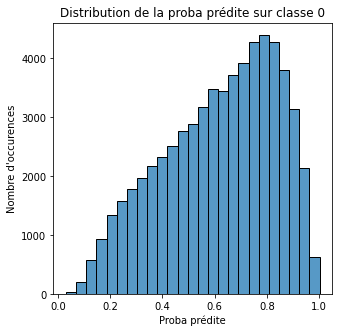

In [108]:
fig, ax = plt.subplots(figsize=(5,5))

sns.histplot(
    x=probs[:,0],
    bins=25
)

ax.set_title('Distribution de la proba prédite sur classe 0')
ax.set_ylabel("Nombre d'occurences")
ax.set_xlabel("Proba prédite")

plt.show()

Nous constatons que l'ensemble de l'espace (0, 1) semble couvert, ce qui nous servira lors de l'élaboration du dashboard notamment.

## 2.7. Création de données annexes

### 2.7.1. Data dictionary

Pour faciliter l'utilisation du dashboard, nous concevons également un data dictionary pour les variables retenues.

In [110]:
model.model.feature_names_in_

array(['REFUSED_APP_CREDIT_PERC_VAR', 'REGION_RATING_CLIENT',
       'EXT_SOURCE_1', 'REFUSED_AMT_CREDIT_MAX',
       'REFUSED_DAYS_DECISION_MEAN', 'DAYS_EMPLOYED', 'EXT_SOURCE_3',
       'DAYS_ID_PUBLISH', 'DAYS_BIRTH', 'AMT_ANNUITY',
       'YEARLY_PAYMENT_RATE', 'NAME_EDUCATION_TYPE_Highereducation',
       'REFUSED_AMT_APPLICATION_MAX', 'REGION_RATING_CLIENT_W_CITY',
       'AMT_GOODS_PRICE', 'INSTAL_DPD_MEAN', 'CODE_GENDER', 'AMT_CREDIT',
       'REFUSED_DAYS_DECISION_MAX', 'EXT_SOURCE_2',
       'NAME_INCOME_TYPE_Working'], dtype=object)

In [112]:
data_dict = dict()
data_dict['REFUSED_APP_CREDIT_PERC_VAR'] = "Variance observée sur les crédits refusés du ratio entre prêt demandé et crédit considéré"
data_dict['REGION_RATING_CLIENT'] = "Note attribuée à la région dans laquelle réside le client (1,2,3)"
data_dict['EXT_SOURCE_1'] = "Score de crédit normalisé, source externe"
data_dict['REFUSED_AMT_CREDIT_MAX'] = "Montant maximal parmi les crédits refusés"
data_dict['REFUSED_DAYS_DECISION_MEAN'] = "Nombre moyen de jours depuis les crédits refusés"
data_dict['DAYS_EMPLOYED'] = "Nombre de jours depuis lesquels le client travaille, sur son poste actuel"
data_dict['EXT_SOURCE_3'] = "Score de crédit normalisé, source externe"
data_dict['DAYS_ID_PUBLISH'] = "Nombre de jours depuis le dernier changement de papiers d'identité du client, au moment de la demande de crédit"
data_dict['DAYS_BIRTH'] = "Age du client, en jours, au moment de la demande de crédit"
data_dict['AMT_ANNUITY'] = "Montant annuel du remboursement pour le crédit considéré"
data_dict['YEARLY_PAYMENT_RATE'] = "Taux de remboursement annuel observé sur crédits"
data_dict['NAME_EDUCATION_TYPE_Highereducation'] = "Client ayant atteint un niveau d'éducation équivalent à l'université"
data_dict['REFUSED_AMT_APPLICATION_MAX'] = "Montant maximal parmi les crédits refusés"
data_dict['REGION_RATING_CLIENT_W_CITY'] = "Note attribuée à la région dans laquelle réside le client (1,2,3), en tenant compte de la ville de résidence"
data_dict['AMT_GOODS_PRICE'] = "Valeur du bien financé, si crédit conso"
data_dict['INSTAL_DPD_MEAN'] = "Moyenne en jours des retards de paiement observés"
data_dict['CODE_GENDER'] = "Genre du client"
data_dict['AMT_CREDIT'] = "Montant demandé pour le crédit"
data_dict['REFUSED_DAYS_DECISION_MAX'] = "Nombre de jours depuis le premier crédit refusé"
data_dict['EXT_SOURCE_2'] = "Score de crédit normalisé, source externe"
data_dict['NAME_INCOME_TYPE_Working'] = "Indicateur si le client est actuellement au statut employé"

# Enregistrement au format json pour exploitation par le dashboard
with open('plots/data_dict.json', 'w') as file:
    json.dump(data_dict, file)

### 2.7.2. Données pour histogrammes

Afin de limiter la taille des bases de données utilisées, tout en permettant de représenter le positionnement du client dans la base client totale (entraînement, validation, test), nous allons exporter les valeurs nécessaires pour créer des histogrammes.

In [113]:
X_test = challenge_set.drop(columns=['SK_ID_CURR', 'TARGET'])
del challenge_set
gc.collect()

26

In [115]:
def extract_hist_val(X, bins=20):
    ax = plt.axes()
    values, bins, patches = ax.hist(X, bins=bins)
    plt.close()
    return values, bins

In [116]:
hist_data = dict()

X = pd.concat([X_train, X_valid, X_test], ignore_index=True)

for feat in features:
    data = X[feat].dropna()
    values, bins = extract_hist_val(data, bins=20)
    hist_data[feat] = {'values': values.tolist(),
                       'bins': bins.tolist(),
                       'mean': data.mean()}

Nous enregistrons ces données au format json également, pour exploitation future.

In [120]:
with open('plots/hist_data.json', 'w') as file:
    json.dump(hist_data, file)

## 2.8. Création d'un modèle SHAP

Afin d'expliquer l'impact de chaque variable sur une prédiction donnée, nous utiliserons l'implémentation de SHAP disponible sous shap.

In [122]:
features = model.model.feature_names_in_

In [123]:
explainer = shap.Explainer(model.predict_proba,
                           X_valid.loc[:, features],
                           feature_names=features,
                           seed=52)

Nous l'enregistrons également pour exploitation future.

In [127]:
joblib.dump(explainer, 'models/explainer.joblib')

['models/explainer.joblib']

### 2.8.1. Interprétabilité globale

Nous étudions désormais l'interprétabilité globale du modèle, sur la base des données du set de test (données client à prédire).

In [34]:
data_set.set_index('SK_ID_CURR', inplace=True)
data_set.index = data_set.index.astype('str')

Pour ce faire, nous évaluons l'ensemble du set au travers de SHAP.

In [12]:
shap_values = explainer(data_set,
                        batch_size='auto',
                        max_evals=max(2*model.model.n_features_in_+1, 50))

Permutation explainer: 48745it [07:57, 99.97it/s]                                                                      


Nous visualisons ensuite le résultat.

In [26]:
shap_val_df = pd.DataFrame(
    shap_values.values[0][:,1].reshape(-1,1),
    index=features,
    columns=['SHAP_imp'])

shap_val_df.sort_values(by='SHAP_imp',
                        axis=0,
                        # ascending=False,
                        key=lambda x: abs(x),
                        inplace=True
                       )

shap_cols = [shap.plots.colors.red_rgb if x>0 else shap.plots.colors.blue_rgb for x in shap_val_df['SHAP_imp']]

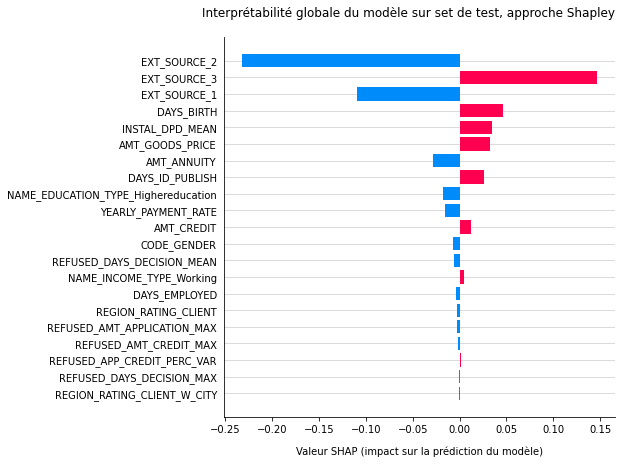

In [32]:
fig, ax = plt.subplots(figsize=(7,7))

plt.barh(
    width=shap_val_df['SHAP_imp'],
    y=shap_val_df.index,
    color=shap_cols
)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('none')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Valeur SHAP (impact sur la prédiction du modèle)", labelpad=12)
ax.set_title("Interprétabilité globale du modèle sur set de test, approche Shapley",
             pad=20, loc='right')
ax.grid(True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

fig.savefig('shap_global.png', bbox_inches='tight')

plt.show()

### 2.8.2. Interprétabilité locale

Nous pouvons également visualiser l'interprétabilité locale, au travers d'un exemple. Pour ce faire, nous prenons le second client de notre liste.

In [21]:
shap_values_cust = explainer(data_set.iloc[[1]],
                             batch_size='auto',
                             max_evals=max(2*model.model.n_features_in_+1, 500))

In [28]:
shap_val_cust_df = pd.DataFrame(
    shap_values_cust.values[0][:,1].reshape(-1,1),
    index=features,
    columns=['SHAP_imp'])

shap_val_cust_df.sort_values(by='SHAP_imp',
                        axis=0,
                        # ascending=False,
                        key=lambda x: abs(x),
                        inplace=True
                       )

shap_cust_cols = [shap.plots.colors.red_rgb if x>0 else shap.plots.colors.blue_rgb for x in shap_val_cust_df['SHAP_imp']]

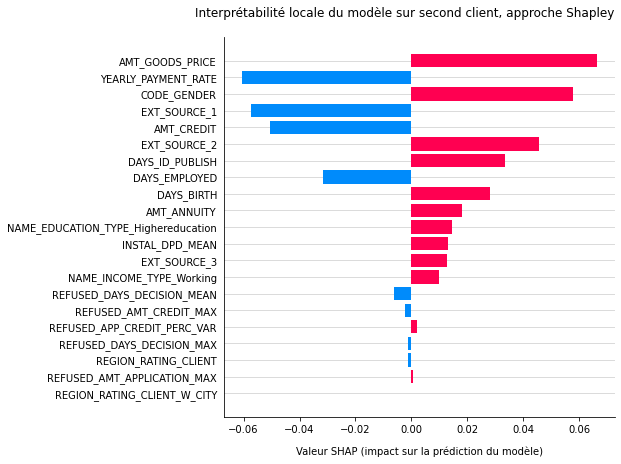

In [33]:
fig, ax = plt.subplots(figsize=(7,7))

plt.barh(
    width=shap_val_cust_df['SHAP_imp'],
    y=shap_val_cust_df.index,
    color=shap_cust_cols
)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('none')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Valeur SHAP (impact sur la prédiction du modèle)", labelpad=12)
ax.set_title("Interprétabilité locale du modèle sur second client, approche Shapley",
             pad=20, loc='right')
ax.grid(True, axis='y', color='lightgrey')
ax.set_axisbelow(True)

fig.savefig('shap_local.png', bbox_inches='tight')

plt.show()